In [56]:
import pandas as pd    # For data manipulation
import numpy as np   # Numerical computations
import itertools   # Cartesian product for hyperparams configs
import matplotlib.pyplot as plt    # Plotting
import seaborn as sns   # Statistical visualizations
import missingno as msno    # Missing data visualizations
import random
import time

# Scikit-learn imports for pipelines, prepocessing, modeling and evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import confusion_matrix
from scipy.stats import loguniform, beta, uniform

# Imbalanced-learn for sampling strategies
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Warnings suppressing
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# How caffeine influences AI devs' productivity

# With this model we are going to try to predict the productivity of AI developers.
# We will use the dataset taken from this link: https://www.kaggle.com/datasets/abhisheksrivastava/ai-dev-productivity
# This model will take into account several features like the hours spent coding, the caffeine intake, the distractions,
# the hours slept, the number of commits, the time spent using some AI tools, the cognitive load and the number of bugs reported 
# and the model will try to categorize the information into two classes: the class of success and the class of insuccess of completing the tasks,
# so the final classification will be a binary classification.

In [3]:
# Let's import the csv and convert it to DataFrame

csv = pd.read_csv("ai_dev_productivity.csv")
df = pd.DataFrame(csv)

In [4]:
df.head()  # Let's visualize the first 5 rows to understand how the table is built

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
0,5.99,600,1,5.8,2,1,0.71,5.4,1
1,4.72,568,2,6.9,5,3,1.75,4.7,1
2,6.30,560,1,8.9,2,0,2.27,2.2,1
3,8.05,600,7,6.3,9,5,1.40,5.9,0
4,4.53,421,6,6.9,4,0,1.26,6.3,1


In [5]:
df.describe() # Let's describe the dataset and summarize the stats

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000
mean,5.015600,463.192000,2.976000,6.975800,4.60800,0.858000,1.510920,4.498200,0.606000
std,1.947253,142.334991,1.678409,1.455965,2.70499,1.102846,1.085557,1.868861,0.489124
min,0.000000,6.000000,0.000000,3.000000,0.00000,0.000000,0.000000,1.000000,0.000000
25%,3.600000,369.500000,2.000000,6.100000,3.00000,0.000000,0.697500,3.175000,0.000000
50%,5.030000,500.500000,3.000000,6.950000,5.00000,0.000000,1.260000,4.400000,1.000000
75%,6.275000,600.000000,4.000000,7.900000,6.00000,2.000000,2.070000,5.800000,1.000000
max,12.000000,600.000000,8.000000,10.000000,13.00000,5.000000,6.360000,10.000000,1.000000


<AxesSubplot: >

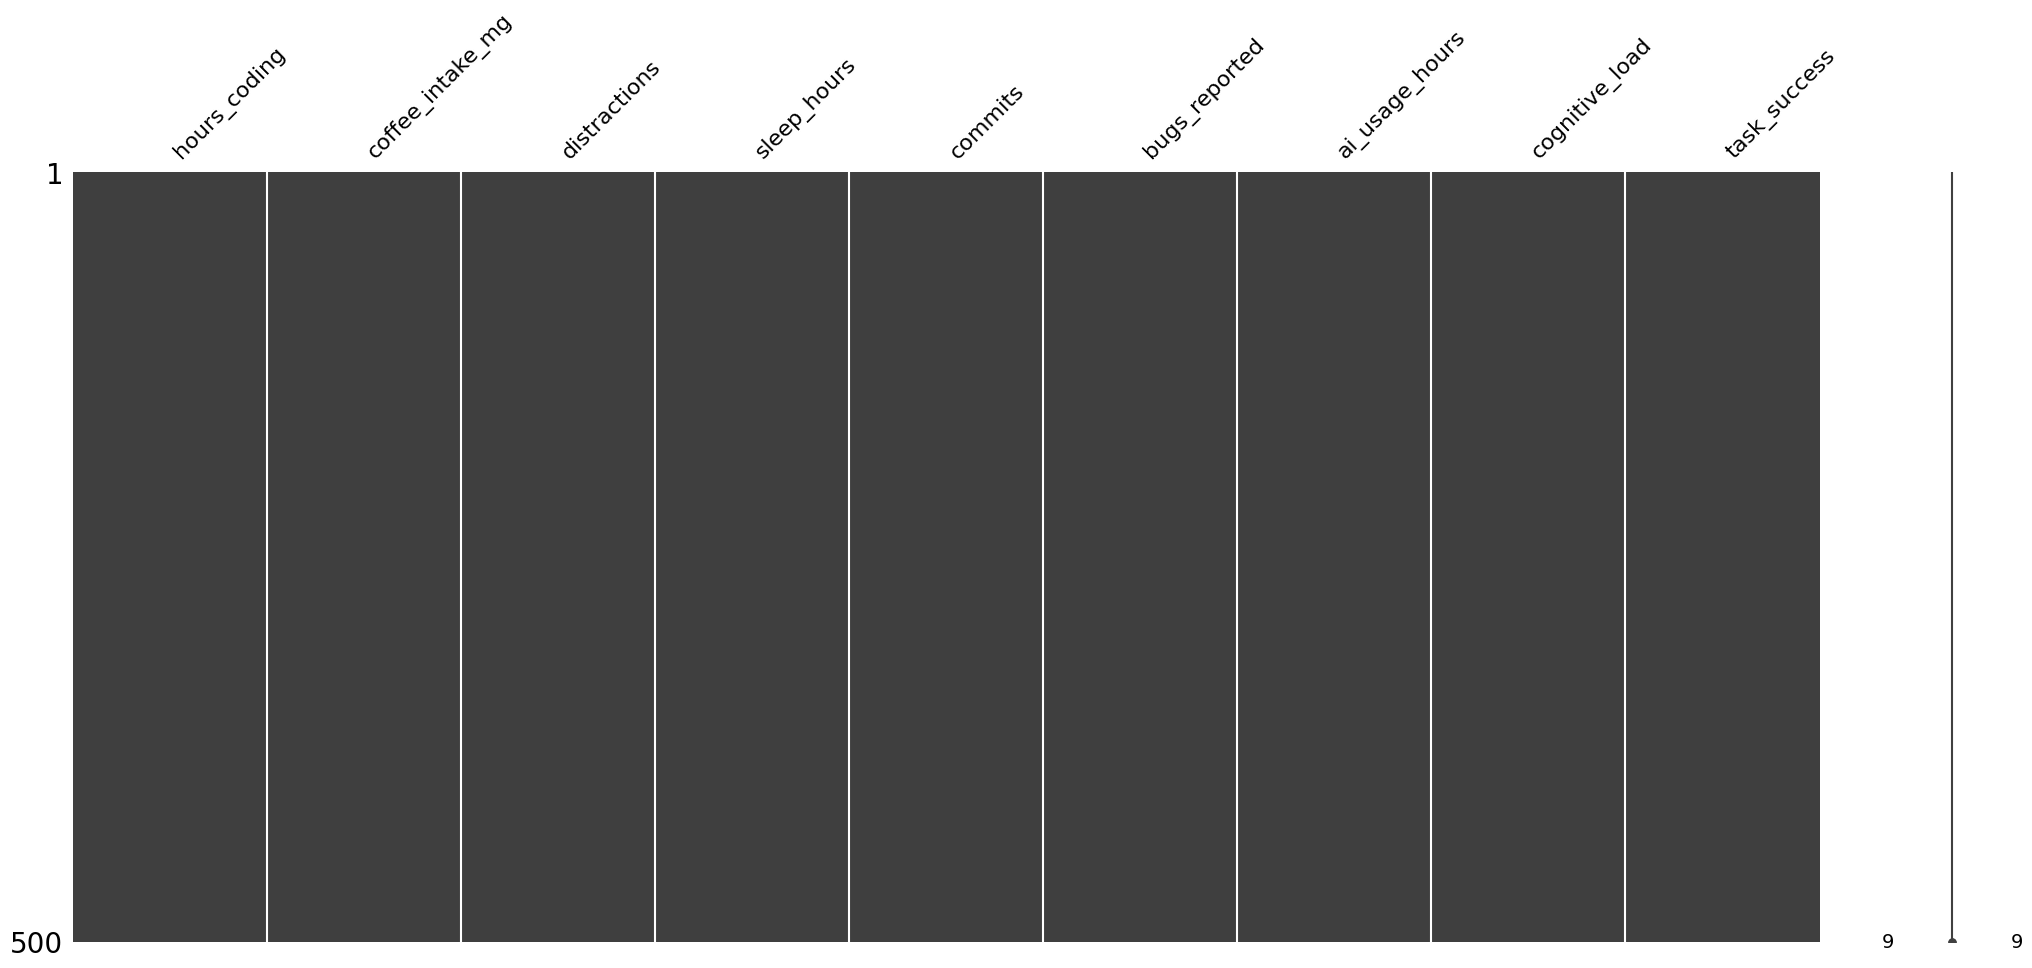

In [6]:
msno.matrix(df) # Visualize the missing data

In [7]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]
X.isnull().sum(axis=0)/X.shape[0]

hours_coding        0.0
coffee_intake_mg    0.0
distractions        0.0
sleep_hours         0.0
commits             0.0
bugs_reported       0.0
ai_usage_hours      0.0
cognitive_load      0.0
dtype: float64

This means that the dataset is perfect. Let's now remove some data.

In [8]:
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace = False )
    X[indexes] = np.nan
    return X

In [9]:
for col in df.columns:
    df[col] = add_missing(df[col], random.uniform(0.08, 0.15))

<AxesSubplot: >

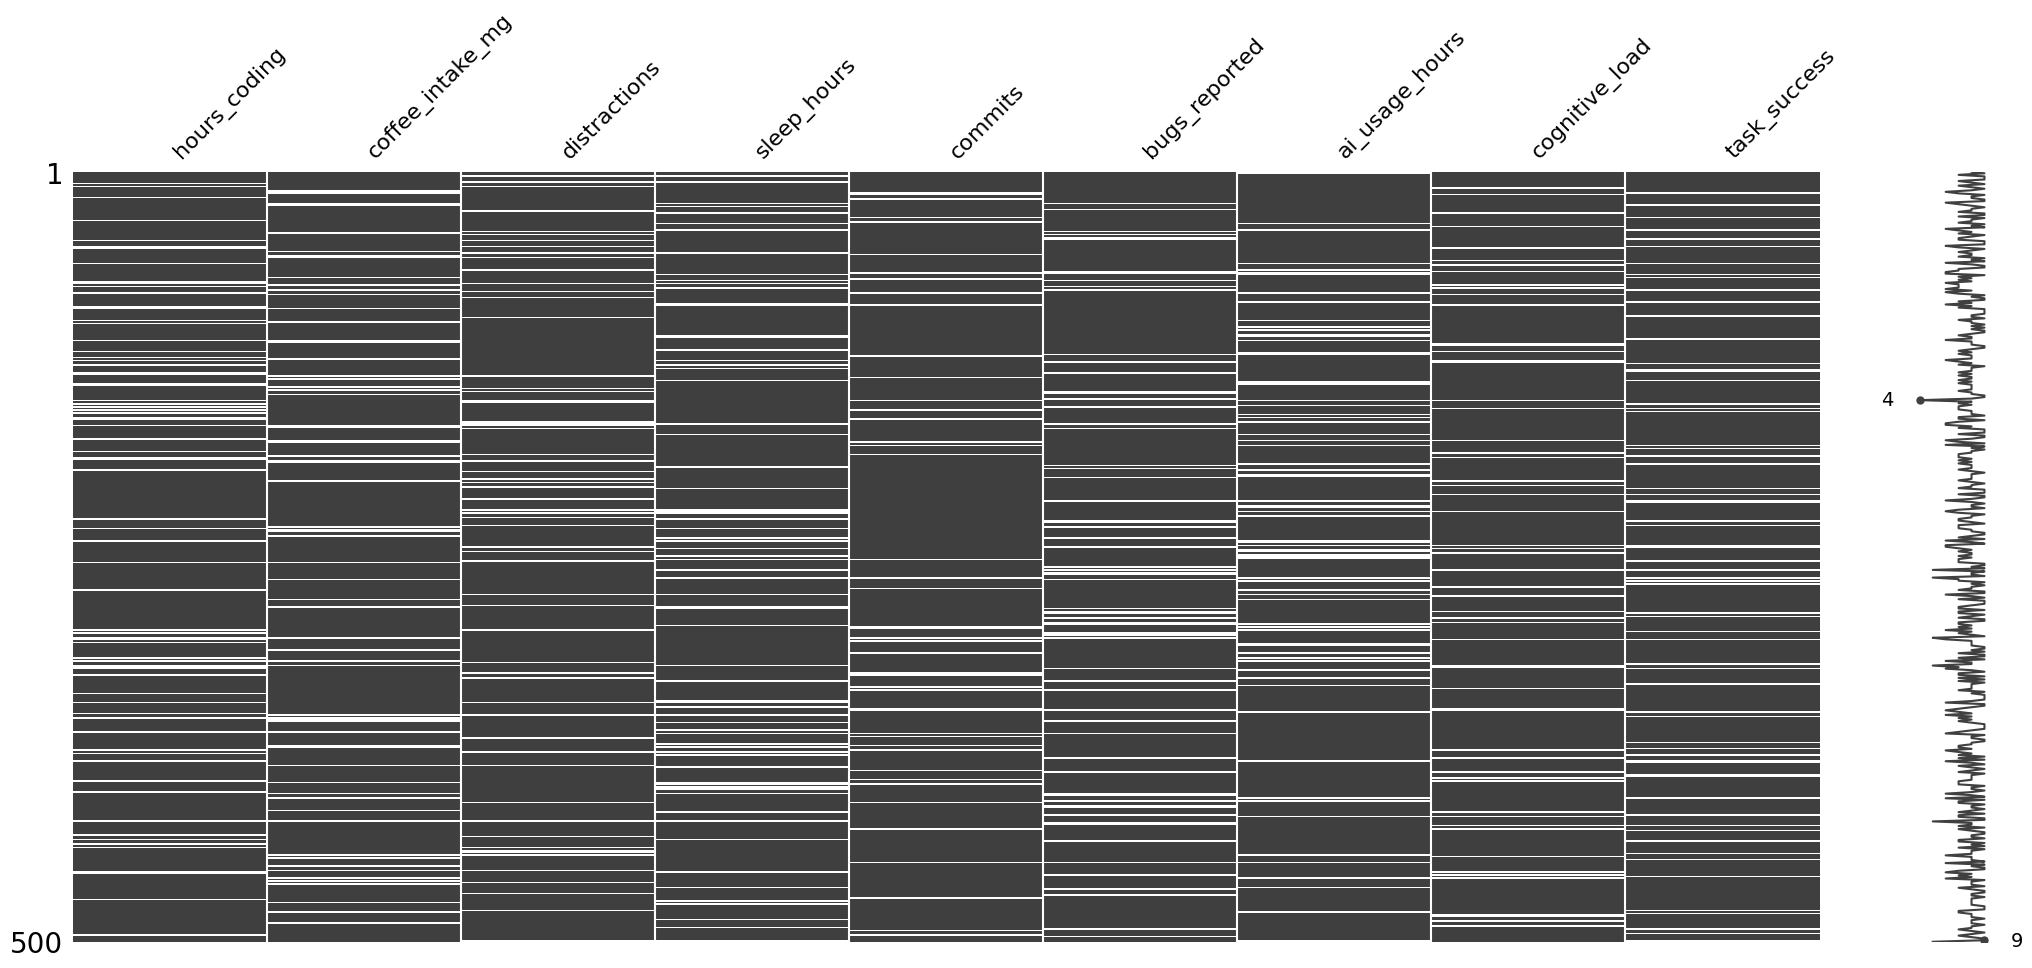

In [10]:
msno.matrix(df)  # Visualize the missing data

<AxesSubplot: >

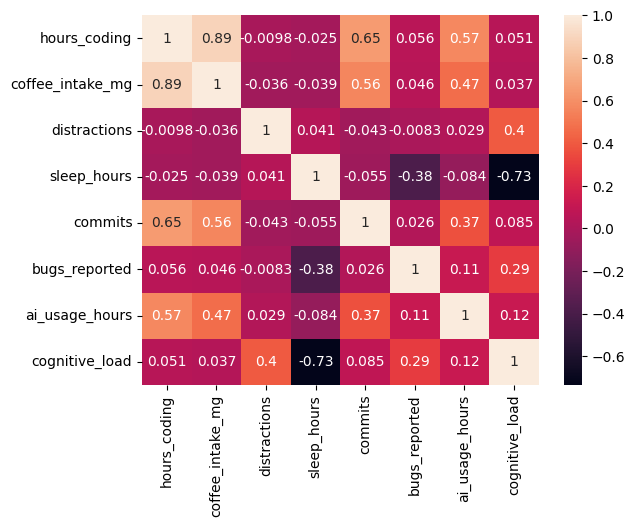

In [11]:
sns.heatmap(X.corr(), annot=True)

From the table above, we can see how the caffeine intake influences the numbers of hours spent coding.

We can imagine that the hours spent coding may have a high relationship with the task success rate. The same holds for the coffee intake, hours slept, numbers of commits and the time spent using some AI tools. On the other hand we can think that the task success' rate has a negative relation with the cognitive load and the distractions. I also think that the numbers of bugs reported does not have a strong relationship with the success' task rate. So we drop the column.

In [12]:
X.drop(columns="bugs_reported", axis=1, inplace=True)

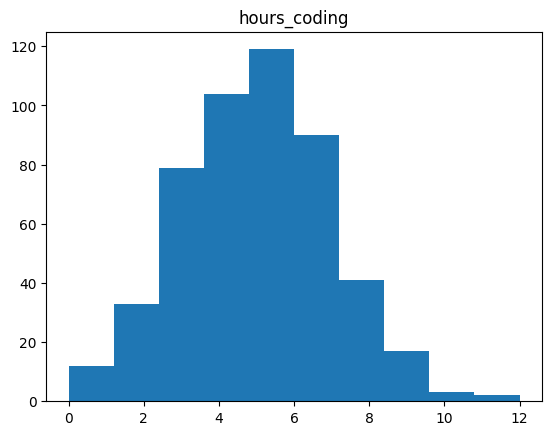

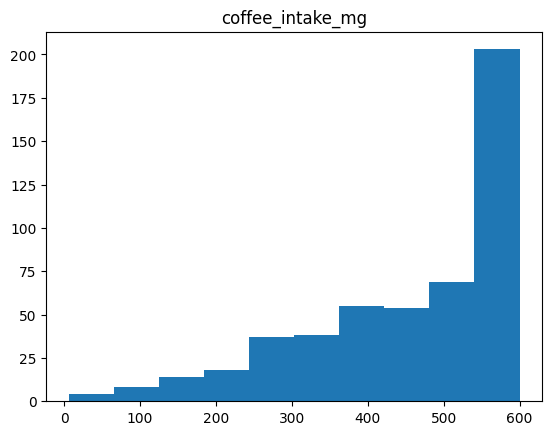

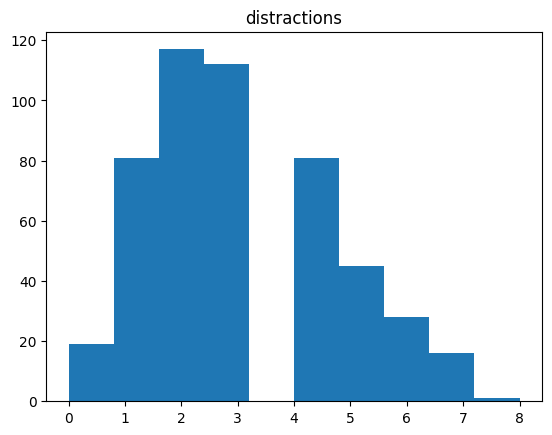

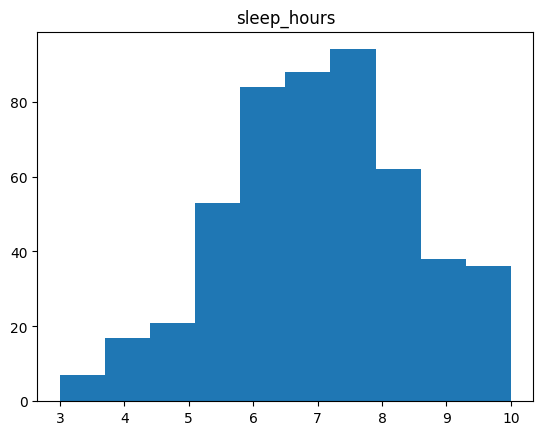

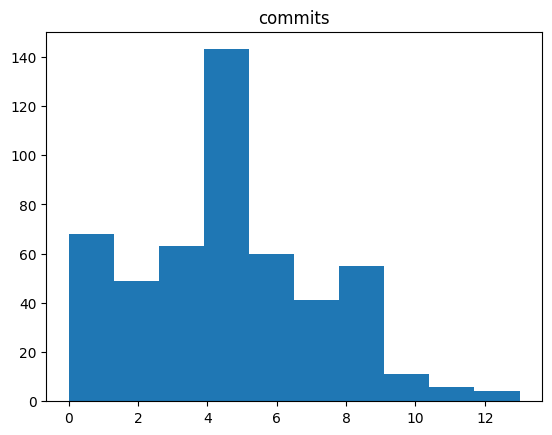

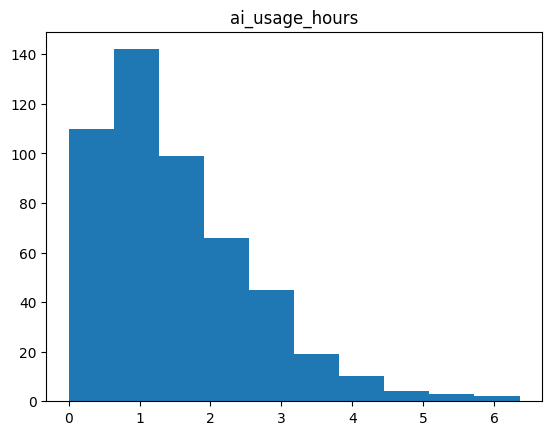

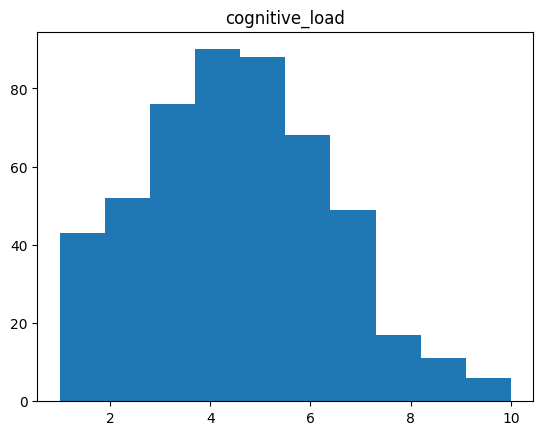

In [13]:
for col in X.columns:
        plt.hist(X[col])
        plt.title(col)
        plt.show()

Let's now create the pipelines

In [14]:
hours_coding_pipe = Pipeline([
    ("imputer", KNNImputer()),  # Impute using nearest neighbors
    ("scaler", StandardScaler())])  # Standardize to zero mean

caffeine_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),  # Mean imputation 
    ("power", PowerTransformer(method="yeo-johnson")) # Stabilize variance
]) 

distraction_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())])

sleep_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())])

commits_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")), # Median for skewed counts
    ("scaler", StandardScaler())])

ai_usage_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())])

cognitive_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())])

I know I can use only one pipeline for type, but for the learning sake I preferred to use a pipeline for each feature

In [15]:
final_transformation = ColumnTransformer(transformers = [
    ("hours_coding", hours_coding_pipe, ["hours_coding"]),
    ("caffeine", caffeine_pipe, ["coffee_intake_mg"]),
    ("distraction", distraction_pipe, ["distractions"]),
    ("sleep", sleep_pipe, ["sleep_hours"]),
    ("commits", commits_pipe, ["commits"]),
    ("ai_usage", ai_usage_pipe, ["ai_usage_hours"]), 
    ("cognitive", cognitive_pipe, ["cognitive_load"])
    ], 
    remainder="passthrough",
    verbose_feature_names_out=False,
    sparse_threshold=0)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 21
)

In [17]:
X_train.head()

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,ai_usage_hours,cognitive_load
406,2.86,218,3,5.6,3,0.99,7.6
407,4.72,509,1,7.1,8,0.78,4.4
176,5.03,447,2,7.4,6,1.33,2.9
300,3.34,381,2,6.4,5,0.88,4.3
474,8.29,600,3,6.9,3,3.55,5.2


In [18]:
model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', SMOTE(random_state=21)),  # Oversample minority class
    ('dim_reduction', PCA(n_components=0.8)),  # Reduce dimensionality
    ('classifier', Perceptron(
        max_iter = 5000,
        tol = 1e-4,
        eta0 = 0.01,
        random_state = 21
    ))
])

In [19]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('hours_coding',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['hours_coding']),
                                                 ('caffeine',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['coffee_intake_mg']),
                                                 ('distraction',
                                                  Pipeline(steps=[('imp...
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ai_usage_hours']),
                                                 ('cognitive',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cognitive_load'])],
                                   verbose_feature_names_out=False)),
                ('sampler', SMOTE(random_state=21)),
                ('dim_reduction', PCA(n_components=0.8)),
                ('classifier',
                 Perceptron(eta0=0.01, max_iter=5000, random_state=21,
                            tol=0.0001))])

In [20]:
model_pipeline.predict(X_test)

array([1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [21]:
sampler_configs = [
    {
        'sampler':[None],  # The element is bypassed
    },
    {
        'sampler':[SMOTE()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

In [22]:
dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]  
    }
]

In [23]:
classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001,100),
        'classifier': [Perceptron()] ,
        'classifier__max_iter': [1,5,10,15,50,100] ,
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C' : loguniform(0.001,100),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,5,7,9]
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10,50,100, 500]
    }
]

In [24]:
regression_configs = [
    {
        'classifier': [LinearRegression()],
        'classifier__fit_intercept' : [True, False]
    }
]

In [25]:
all_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

In [26]:
f"Number of configurations: {len(all_configs)}"

'Number of configurations: 48'

In [27]:
all_configs[:2]

[{'sampler': [None],
  'dim_reduction': [None],
  'classifier__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f1f898c5270>,
  'classifier': [Perceptron()],
  'classifier__max_iter': [1, 5, 10, 15, 50, 100],
  'classifier__class_weight': [None, 'balanced']},
 {'sampler': [None],
  'dim_reduction': [None],
  'classifier': [LogisticRegression(solver='saga')],
  'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f1f898c42b0>,
  'classifier__penalty': ['l1', 'l2'],
  'classifier__class_weight': [None, 'balanced']}]

In [28]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 10,
    n_jobs=-1,
    cv = 2,
    scoring='f1'
)

In [65]:
start = time.time()
scores = cross_validate(rs, X_train, y_train, scoring='f1', cv = 5, return_estimator=True, verbose=3) #3 minutes
end = time.time()
print('\n')
print(f'Elapsed time: {round(end - start, 1)} seconds')

/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of i

In [62]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

RandomOverSampler(sampling_strategy=0.7)
SequentialFeatureSelector(cv=None, estimator=Perceptron(), k_features=(5, 5),
                          scoring='f1')
RandomForestClassifier(n_estimators=10) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.9795918367346939
----------
RandomOverSampler(sampling_strategy=0.7)
SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          k_features=(7, 7), scoring='f1')
RandomForestClassifier(n_estimators=500) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 

In [31]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.9979381443298969, F1 on test set:0.9836065573770492
F1 on training set:1.0, F1 on test set:0.9917355371900827
F1 on training set:1.0, F1 on test set:0.9917355371900827
F1 on training set:1.0, F1 on test set:0.9917355371900827
F1 on training set:1.0, F1 on test set:0.9917355371900827


In [32]:
best_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('classifier',LogisticRegression(solver='saga', penalty = 'l1'))
])

In [33]:
params = {
    'classifier__C': uniform(loc = 5, scale = 10)
}

In [71]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1),
    n_iter=20,
    scoring='f1'
)

In [74]:
rs_best.fit(X_train, y_train)

AttributeError: 'RandomizedSearchCV' object has no attribute 'rs_best'

In [68]:
rs_best.best_estimator_

NameError: name 'best_rscv' is not defined

In [37]:
f1_score(y_test, rs_best.best_estimator_.predict(X_test))

0.896551724137931

In [ ]:
cls = rs_best.best_estimator_

In [39]:
train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = False)

/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

ValueError: x and y must have same first dimension, but have shapes (11,) and (6,)

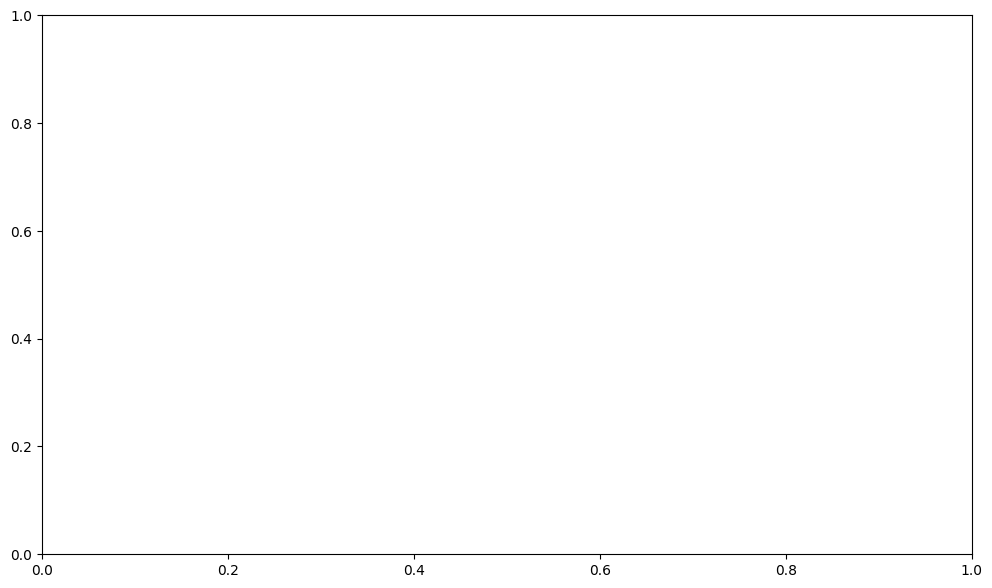

In [50]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training F1')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation F1')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.70, 1.00])

In [41]:
range_C = [0.001,0.01,0.1,1,10,100]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=
        range_C, 
        param_name='classifier__C',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)

(0.05, 100)

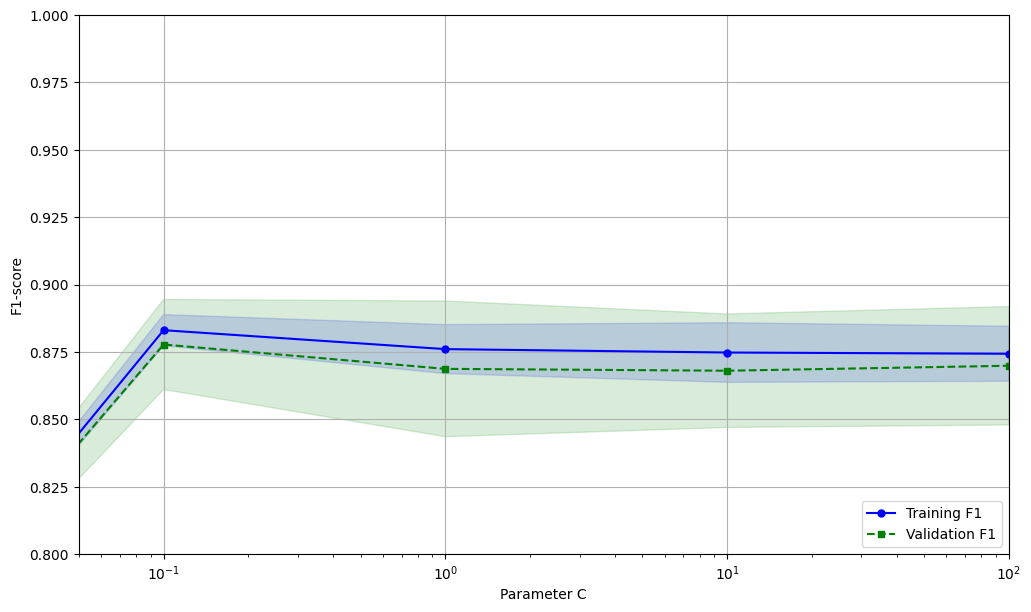

In [42]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_C, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training F1')

ax.fill_between(range_C,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_C, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation F1')

ax.fill_between(range_C,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter C')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.8, 0.95])
ax.set_xscale('log')
ax.set_xlim([0.05,100])

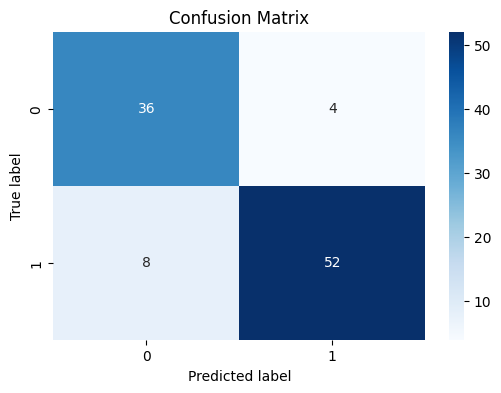

In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions for the test set
y_pred = rs_best.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Let's now try with my info

In [44]:
X.columns

Index(['hours_coding', 'coffee_intake_mg', 'distractions', 'sleep_hours',
       'commits', 'ai_usage_hours', 'cognitive_load'],
      dtype='object')

In [45]:
X.describe

<bound method NDFrame.describe of      hours_coding  coffee_intake_mg  distractions  sleep_hours  commits  \
0            5.99               600             1          5.8        2   
1            4.72               568             2          6.9        5   
2            6.30               560             1          8.9        2   
3            8.05               600             7          6.3        9   
4            4.53               421             6          6.9        4   
..            ...               ...           ...          ...      ...   
495          6.08               594             1          5.3        3   
496          2.93               382             2          6.7        3   
497          4.62               494             4          7.5        2   
498          3.25               296             6          6.9        1   
499          2.23               252             4          8.8        0   

     ai_usage_hours  cognitive_load  
0              0.71        

In [46]:
me = pd.DataFrame([[5.5, 100, 4, 6.5, 4, 1.5, 5.5]], columns=["hours_coding", "coffee_intake_mg", "distractions", "sleep_hours", "commits", "ai_usage_hours", "cognitive_load"])

In [47]:
predicted_label = rs_best.predict(me)
print("Prediction:", predicted_label[0])

Prediction: 0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bce08907-56a5-41ec-b452-5d4ec5f45e11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>